In [1]:
from ML.PreProcessing import PreProcessCorpus
from ML.FeatureEngineering import FeatureEngineering
from ML.ModelTraining import Gdb
import numpy as np
import catboost as cb

ModuleNotFoundError: No module named 'catboost'

In [5]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn import ensemble
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn import svm
import matplotlib.pyplot as plt
import seaborn as sess
sess.set()

In [7]:
corpus = PreProcessCorpus(dir_path=r"C:\ProjectNLP\FakeNewsData\StoryText 2")
train_data, validation_data, test_data = corpus.generate_data_frame()

fe = FeatureEngineering(data=train_data)
fe.train_bag_of_words(2)
train_bag_of_words = fe.generate_bag_of_words(train_data['sentences'])
validation_bag_of_words = fe.generate_bag_of_words(validation_data['sentences'])
test_bag_of_words = fe.generate_bag_of_words(test_data['sentences'])

tfidf_train = fe.find_diff_tfidf(train_bag_of_words, labels=train_data["text type"], file_path=train_data["file path"],
                                diff_size=200, satire_size=500, fake_size=500)
tfidf_validation = {"tfidf":fe.transfer_diff_tfidf(validation_bag_of_words), "file path": validation_data["file path"],
                    "labels": validation_data["text type"]}
tfidf_test = {"tfidf":fe.transfer_diff_tfidf(test_bag_of_words), "file path": test_data["file path"],
              "labels": test_data["text type"]}

tfidf_train["labels"] = 1 * (tfidf_train["labels"] == "fake")
tfidf_validation["labels"] = 1 * (tfidf_validation["labels"] == "fake")
tfidf_test["labels"] = 1 * (tfidf_test["labels"] == "fake")

IndexError: index (6011) out of range

In [4]:
x_train = tfidf_train["tfidf"]
y_train = tfidf_train["labels"].values
x_validation = tfidf_validation["tfidf"]
y_validation = tfidf_validation["labels"].values
x_test = tfidf_test["tfidf"]
y_test = tfidf_test["labels"].values

In [95]:
cb_estimator = cb.CatBoostClassifier(verbose=1, depth=4, learning_rate = 0.1,metric_period=20, iterations= 500,
                 random_seed=0,feature_border_type="GreedyLogSum",random_strength=100, od_pval=0.01, class_weights=[0.6,0.4])
eval_dataset  = cb.Pool( x_validation, y_validation)  
cb_estimator.fit(x_train, y_train)

# gb_estimator = ensemble.GradientBoostingClassifier(criterion='mse', verbose=1, subsample=1, n_estimators=500, max_depth=3,max_features="sqrt",
#                                                   n_iter_no_change=10, learning_rate=0.1)
# gb_estimator.fit(x_train, y_train)

# hist_estimator = ensemble.HistGradientBoostingClassifier(verbose=1)
# hist_estimator.fit(x_train, y_train)

# clf = svm.SVC(probability=True)
# clf.fit(x_train, y_train)

0:	learn: 0.6928330	total: 9.84ms	remaining: 4.91s
20:	learn: 0.6855230	total: 114ms	remaining: 2.6s
40:	learn: 0.6780762	total: 216ms	remaining: 2.42s
60:	learn: 0.6694284	total: 329ms	remaining: 2.37s
80:	learn: 0.6617214	total: 434ms	remaining: 2.25s
100:	learn: 0.6527489	total: 537ms	remaining: 2.12s
120:	learn: 0.6380652	total: 644ms	remaining: 2.02s
140:	learn: 0.6106692	total: 751ms	remaining: 1.91s
160:	learn: 0.5872725	total: 857ms	remaining: 1.8s
180:	learn: 0.5675454	total: 960ms	remaining: 1.69s
200:	learn: 0.5504970	total: 1.06s	remaining: 1.58s
220:	learn: 0.5351568	total: 1.17s	remaining: 1.47s
240:	learn: 0.5228794	total: 1.27s	remaining: 1.37s
260:	learn: 0.5111299	total: 1.38s	remaining: 1.26s
280:	learn: 0.4997569	total: 1.49s	remaining: 1.16s
300:	learn: 0.4890054	total: 1.6s	remaining: 1.05s
320:	learn: 0.4792302	total: 1.71s	remaining: 953ms
340:	learn: 0.4703443	total: 1.82s	remaining: 849ms
360:	learn: 0.4615325	total: 1.93s	remaining: 742ms
380:	learn: 0.452874

In [96]:
validation_pred = cb_estimator.predict_proba(x_validation)[:,1]

<b>sentence accuracy:</b>

In [97]:
accuracy = accuracy_score(1*(np.array(validation_pred)>0.5), y_validation)
print(f"The accuracy score is: {accuracy}")

The accuracy score is: 0.6401590457256461


In [98]:
cfs_matrix = confusion_matrix(1*(np.array(validation_pred)>0.5), y_validation)
print(f"The confusion matrix:")
print(cfs_matrix)

The confusion matrix:
[[420 268]
 [275 546]]


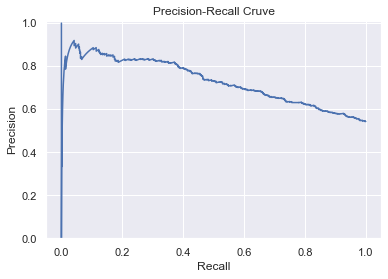

In [99]:
precision, recall, thresholds = precision_recall_curve(y_validation, validation_pred)
plt.plot(recall, precision);
plt.ylabel("Precision");
plt.xlabel("Recall");
plt.title("Precision-Recall Cruve");
plt.ylim([0,1.01]);

<b>article accuracy:</b>

In [100]:
pred_values = []
labels = []
unique_files = tfidf_validation["file path"].unique()
for pfile in unique_files:
    file_mask = (tfidf_validation["file path"] == pfile)
    pred = np.mean(validation_pred[file_mask])
    label = np.mean(y_validation[file_mask])
    pred_values.append(pred)
    labels.append(label)

In [101]:
labels = np.array(labels)
accuracy = accuracy_score(1*(np.array(pred_values)>0.5), labels)
print(f"The accuracy score is: {accuracy}")

The accuracy score is: 0.7407407407407407


In [102]:
cfs_matrix = confusion_matrix(1*(np.array(pred_values)>0.5), labels)
print(f"The confusion matrix:")
print(cfs_matrix)

The confusion matrix:
[[19  8]
 [13 41]]


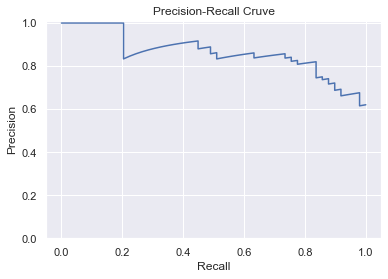

In [103]:
precision, recall, thresholds = precision_recall_curve(labels, pred_values)
plt.plot(recall, precision);
plt.ylabel("Precision");
plt.xlabel("Recall");
plt.title("Precision-Recall Cruve");
plt.ylim([0,1.01]);

<b>test article accuracy:</b>

In [107]:
test_pred = cb_estimator.predict_proba(x_test)[:,1]

In [108]:
pred_values = []
labels = []
unique_files = tfidf_test["file path"].unique()
for pfile in unique_files:
    file_mask = (tfidf_test["file path"] == pfile)
    pred = np.mean(test_pred[file_mask])
    label = np.mean(y_test[file_mask])
    pred_values.append(pred)
    labels.append(label)

In [109]:
labels = np.array(labels)
accuracy = accuracy_score(1*(np.array(pred_values)>0.5), labels)
print(f"The accuracy score is: {accuracy}")

The accuracy score is: 0.7777777777777778


In [110]:
cfs_matrix = confusion_matrix(1*(np.array(pred_values)>0.5), labels)
print(f"The confusion matrix:")
print(cfs_matrix)

The confusion matrix:
[[18  3]
 [15 45]]


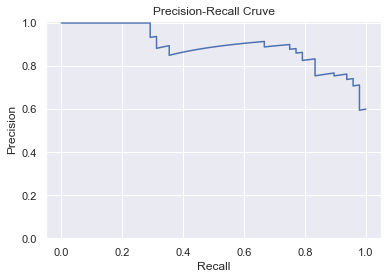

In [111]:
precision, recall, thresholds = precision_recall_curve(labels, pred_values)
plt.plot(recall, precision);
plt.ylabel("Precision");
plt.xlabel("Recall");
plt.title("Precision-Recall Cruve");
plt.ylim([0,1.01]);

<b>Train all data for web</b>

In [115]:
model_path = r"ML\SavedModels\cataboost_classifier.cbm"
cb_estimator.save_model(model_path, format="cbm", export_parameters=None)

In [117]:
del cb_estimator
cb_estimator

NameError: name 'cb_estimator' is not defined

In [119]:
cb_estimator = cb.CatBoostClassifier()
cb_estimator.load_model(model_path)

In [128]:
x_train_validation = np.concatenate([x_train, x_validation])
y_train_validation = np.concatenate([y_train, y_validation])

In [130]:
cb_estimator = cb.CatBoostClassifier(verbose=1, depth=4, learning_rate = 0.1,metric_period=20, iterations= 500,
                 random_seed=0,feature_border_type="GreedyLogSum",random_strength=100, od_pval=0.01, class_weights=[0.6,0.4])
eval_dataset  = cb.Pool( x_test, y_test)  
cb_estimator.fit(x_train_validation, y_train_validation, eval_set = eval_dataset)

0:	learn: 0.6926915	test: 0.6934140	best: 0.6934140 (0)	total: 10.2ms	remaining: 5.08s
20:	learn: 0.6844787	test: 0.6938500	best: 0.6934140 (0)	total: 126ms	remaining: 2.87s
40:	learn: 0.6739746	test: 0.6846096	best: 0.6842618 (37)	total: 242ms	remaining: 2.7s
60:	learn: 0.6630450	test: 0.6739530	best: 0.6739530 (60)	total: 361ms	remaining: 2.6s
80:	learn: 0.6554947	test: 0.6687720	best: 0.6687720 (80)	total: 478ms	remaining: 2.47s
100:	learn: 0.6507375	test: 0.6673242	best: 0.6671177 (94)	total: 594ms	remaining: 2.34s
120:	learn: 0.6377794	test: 0.6583135	best: 0.6583135 (120)	total: 711ms	remaining: 2.23s
140:	learn: 0.6141407	test: 0.6424117	best: 0.6424117 (140)	total: 826ms	remaining: 2.1s
160:	learn: 0.5919582	test: 0.6320778	best: 0.6320778 (160)	total: 943ms	remaining: 1.99s
180:	learn: 0.5741271	test: 0.6304107	best: 0.6304107 (180)	total: 1.06s	remaining: 1.88s
200:	learn: 0.5588601	test: 0.6336061	best: 0.6299250 (183)	total: 1.19s	remaining: 1.76s
220:	learn: 0.5457258	test

In [134]:
model_path = r"ML\SavedModels\cataboost_classifier.cbm"
cb_estimator.save_model(model_path, format="cbm", export_parameters=None)